In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample(image, mask, title=""):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    if image.ndim == 3:  # Check if the mask is one-hot encoded
        image = np.argmax(image, axis=-1)  # Convert one-hot encoded mask to single-channel

    plt.imshow(image, cmap='gray')
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    if mask.ndim == 3:  # Check if the mask is one-hot encoded
        mask = np.argmax(mask, axis=-1)  # Convert one-hot encoded mask to single-channel
    plt.imshow(mask, cmap='gray')  # Using 'jet' to provide distinct colors to different classes
    plt.title('Mask')
    plt.axis('off')
    
    plt.suptitle(title)
    plt.show()

def unique_colors(mask_image):
    unique = np.unique(mask_image.reshape(-1, mask_image.shape[2]), axis=0)
    return unique



In [2]:
import numpy as np
from skimage.io import imshow
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.io import imread
import os

def color_map(N=256, normalized=True):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap


def color_map_viz():
    labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void']
    nclasses = 21
    row_size = 50
    col_size = 500
    cmap = color_map()
    array = np.empty((row_size*(nclasses+1), col_size, cmap.shape[1]), dtype=cmap.dtype)
    for i in range(nclasses):
        array[i*row_size:i*row_size+row_size, :] = cmap[i]
    array[nclasses*row_size:nclasses*row_size+row_size, :] = cmap[-1]
    
    imshow(array)
    plt.yticks([row_size*i+row_size/2 for i in range(nclasses+1)], labels)
    plt.xticks([])
    plt.show()


def color_map_label(normalized=True):
    labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void']
    nclasses = 21
    cmap = color_map()
    label_colors = np.empty((nclasses + 1, 3), dtype=cmap.dtype)  # +1 for the 'void' label

    for i in range(nclasses + 1):
        label_colors[i] = cmap[i] if i < nclasses else cmap[-1]

    return label_colors




In [3]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import os
import imageio
from concurrent.futures import ThreadPoolExecutor


def preprocess_and_save(image_path, mask_path, cmap, output_size=(224, 224), output_dir='output', log = False):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load and resize image
    # image = imread(image_path)

    # # Load and resize mask
    # mask_image = imread(mask_path)
    
    image = imageio.imread(image_path)
    mask_image = imageio.imread(mask_path)
    if log:
        plot_sample(image, mask_image, title=f"{image_path}")

    mask_image = resize(mask_image, output_size, anti_aliasing=False, preserve_range=True).astype(int)
    image = resize(image, output_size, anti_aliasing=True) / 255.0  # Normalize to [0, 1]


    # Map color to channel index
    color_to_index = {tuple(val): idx for idx, val in enumerate(cmap)}

    # Initialize 22-channel binary mask
    channels = np.zeros((*output_size, 22), dtype=np.float32)

    # Vectorized mask processing
    # for idx, val in enumerate(cmap):
    #     channels[:, :, idx] = np.all(mask_image == val, axis=-1)

    channels = np.zeros((*output_size, 22), dtype=np.float32)  # Assuming 22 classes including background
    for idx, color in enumerate(cmap):
        mask = np.all(mask_image == np.array(color*256, dtype=int), axis=-1)
        if log:
            print(mask)    
        channels[:, :, idx] = mask
    if log:
        plot_sample(image, channels, title=f"Sample")
        # Use this in your preprocessing function to log unique colors of some masks
        print("Unique colors in mask:", unique_colors(mask_image))

    # Save image and mask to binary files
    image_filename = os.path.join(output_dir, os.path.basename(image_path) + '_image.npy')
    mask_filename = os.path.join(output_dir, os.path.basename(mask_path) + '_mask.npy')
    np.save(image_filename, image)
    np.save(mask_filename, channels)

def process_dataset(image_dir, mask_dir, cmap):
    file_names = os.listdir(image_dir)
    tasks = []
    count = 1
    log = False
    with ThreadPoolExecutor(max_workers=4) as executor:
        for file_name in file_names:
            count+=1
            if count > 10:
                log = False
            if file_name.endswith('.jpg'):
                mask_name = file_name[:-4] + '.png'  # Change extension for mask
                mask_path = os.path.join(mask_dir, mask_name)
                image_path = os.path.join(image_dir, file_name)

                if os.path.exists(mask_path):
                    tasks.append(executor.submit(preprocess_and_save, image_path, mask_path, cmap, (224, 224), 'output', log))

    # Optional: wait for all tasks to complete and handle exceptions
    for task in tasks:
        task.result()  # This will raise any exceptions caught during the thread execution

# Assume color_map function is defined and provides the cmap array
cmap = color_map_label()  # Assuming this function returns the correct RGB values for each class

image_dir = 'data/VOC2007/JPEGImages'
mask_dir = 'data/VOC2007/SegmentationClass'
process_dataset(image_dir, mask_dir, cmap)


/tmp/ipykernel_102256/1829778592.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
/tmp/ipykernel_102256/1829778592.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_image = imageio.imread(mask_path)


In [4]:
import numpy as np
import os

def load_data(directory):
    images = []
    masks = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('_image.npy'):
            images.append(np.load(os.path.join(directory, filename)))
        elif filename.endswith('_mask.npy'):
            masks.append(np.load(os.path.join(directory, filename)))
    return np.array(images), np.array(masks)


from sklearn.model_selection import train_test_split

def split_data(images, masks, train_size=0.8, test_size=0.1, random_state=42):
    # Split into train and remaining (test + validation)
    X_train, X_temp, y_train, y_temp = train_test_split(
        images, masks, train_size=train_size, random_state=random_state, shuffle=True)

    # Split the remaining into test and validation
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=random_state, shuffle=True)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

output_dir = 'output'
images, masks = load_data(output_dir)
print(images.shape)
print(masks.shape)

# Split the data
train_imgs, val_imgs, test_imgs, train_masks, val_masks, test_masks = split_data(images, masks)


(422, 224, 224, 3)
(422, 224, 224, 22)


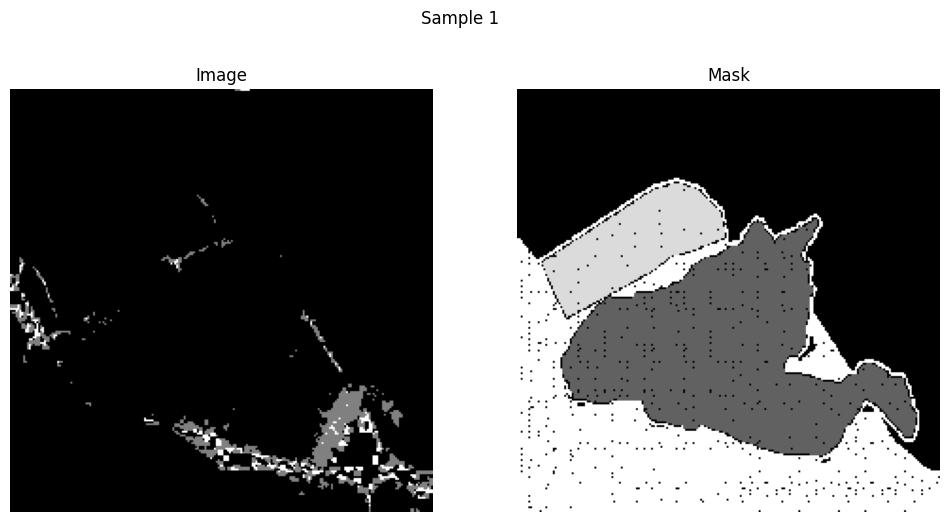

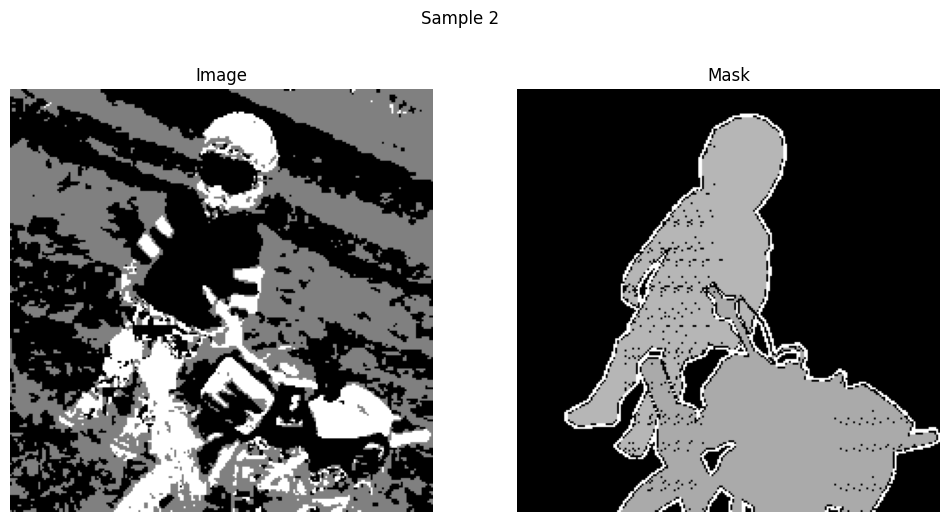

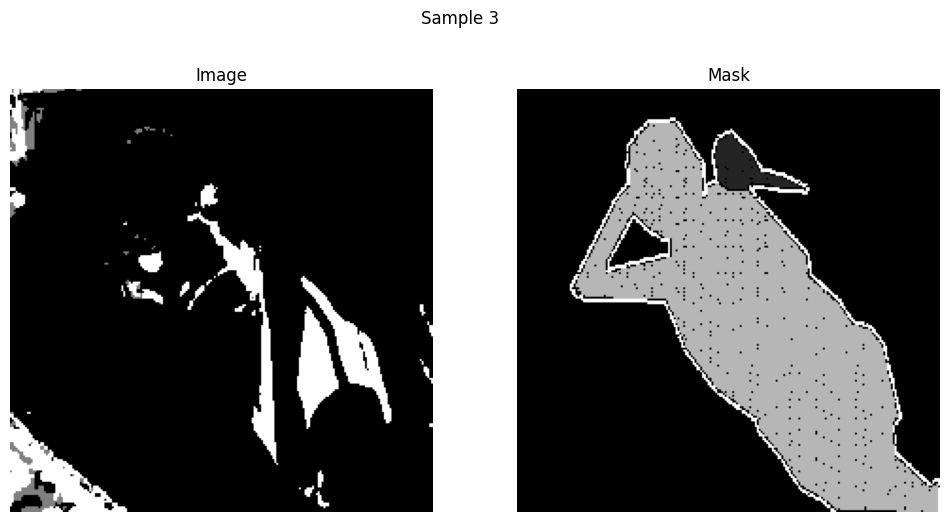

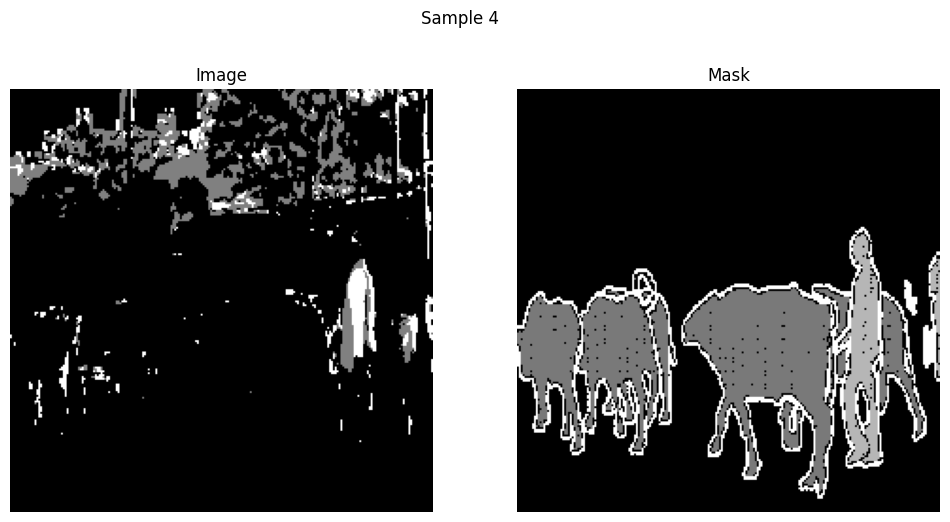

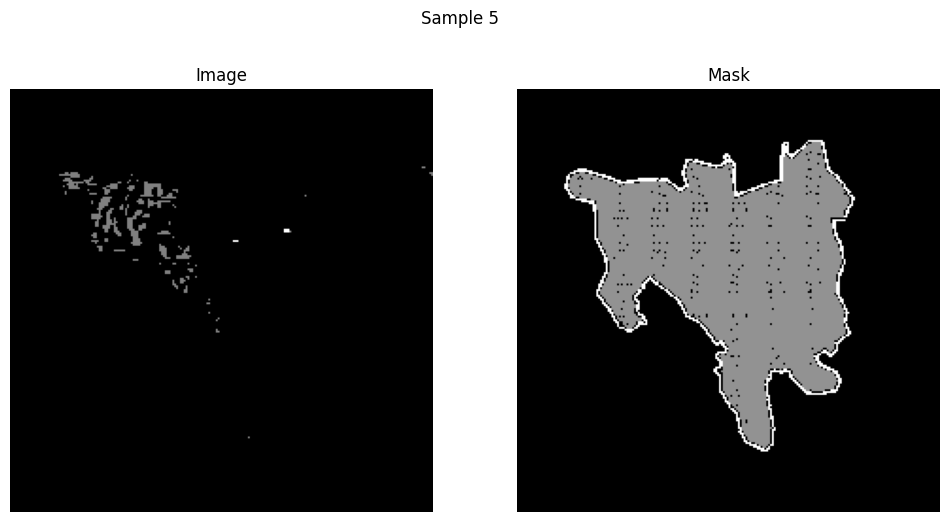

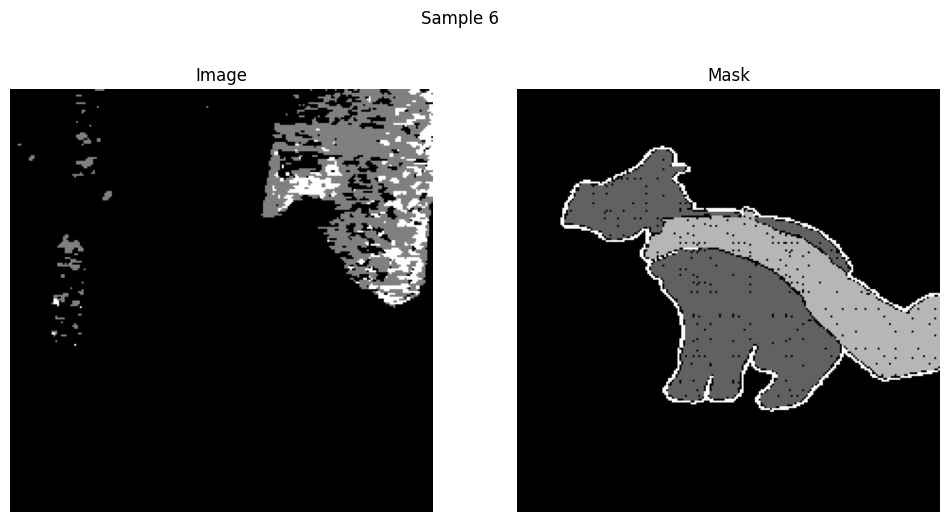

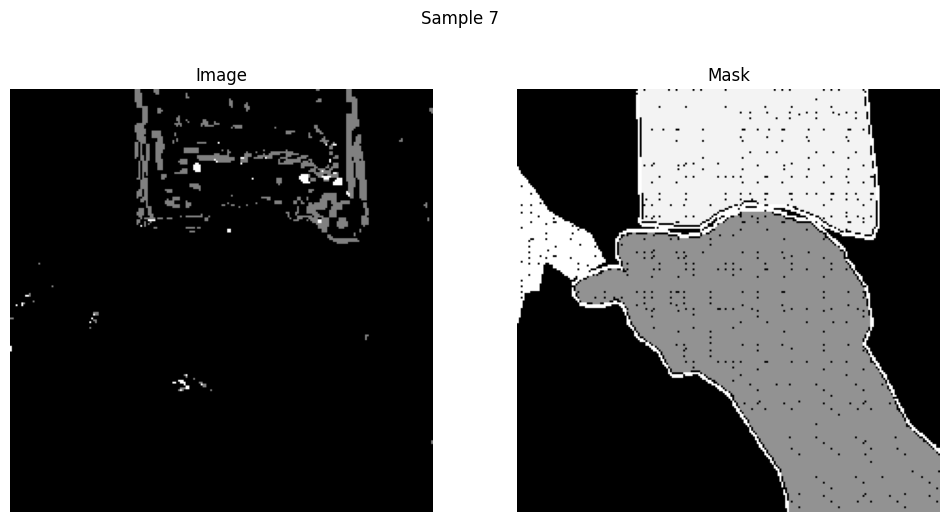

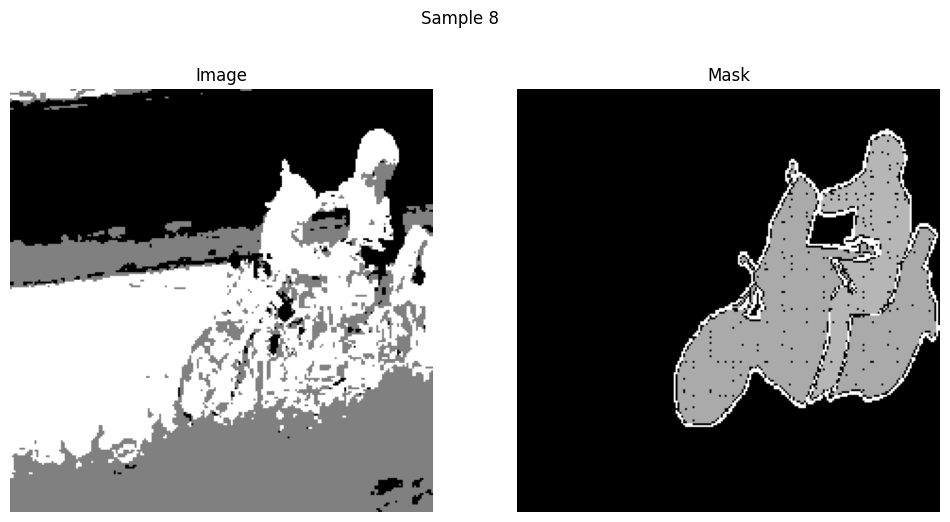

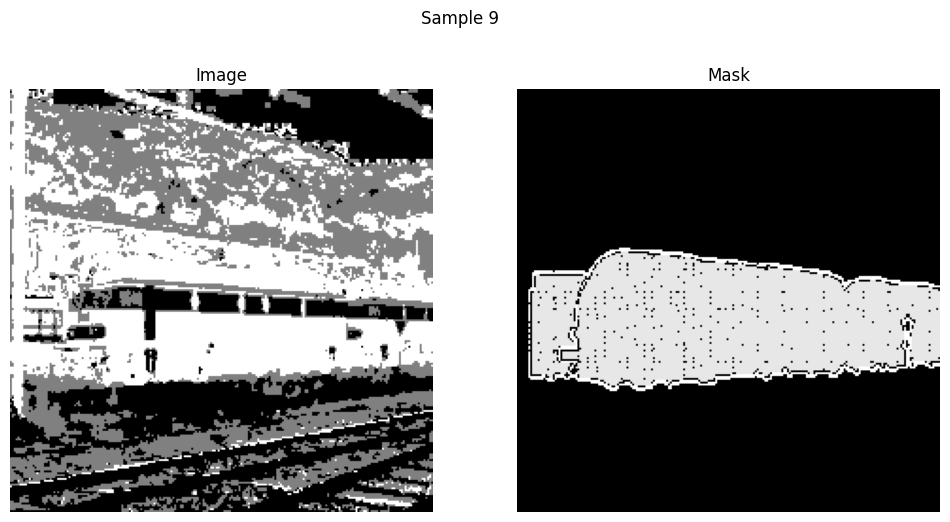

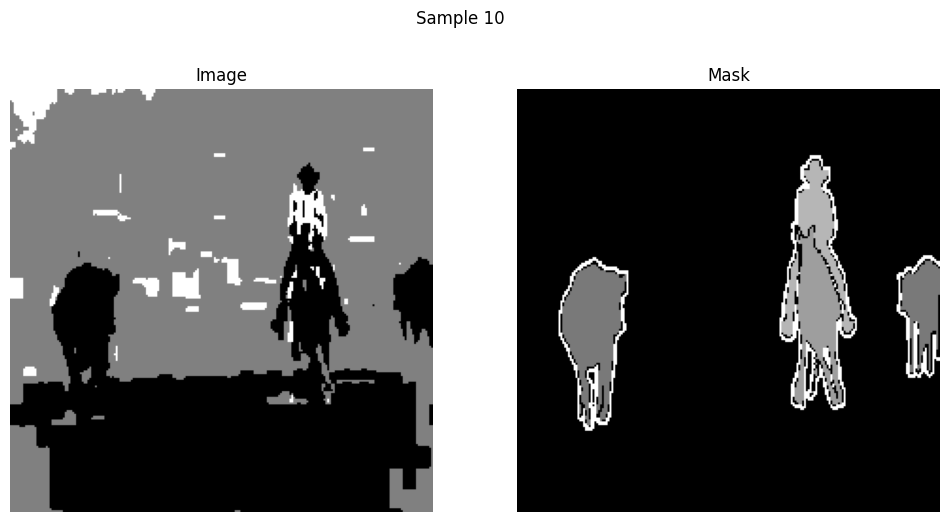

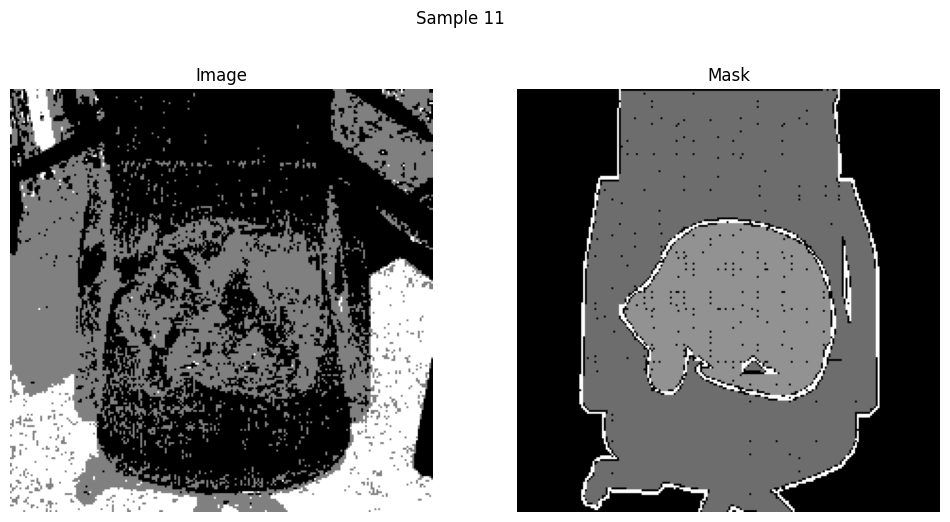

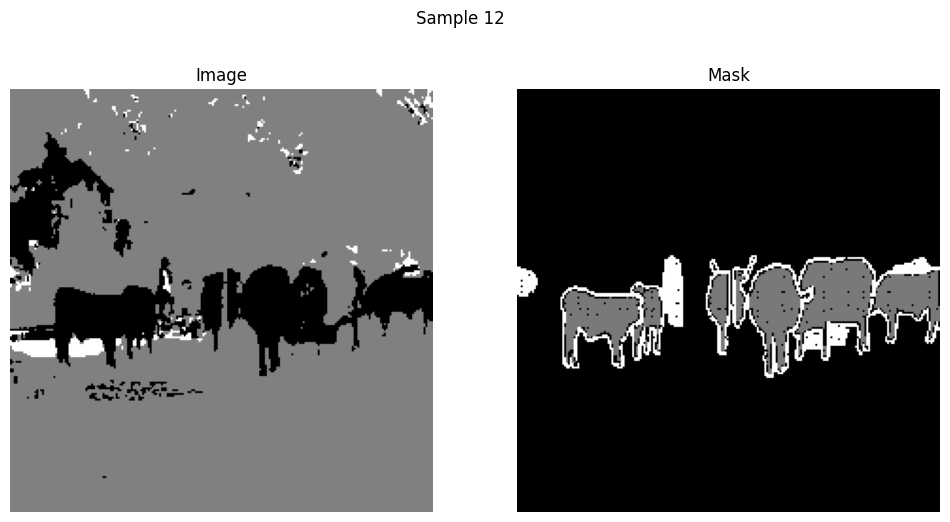

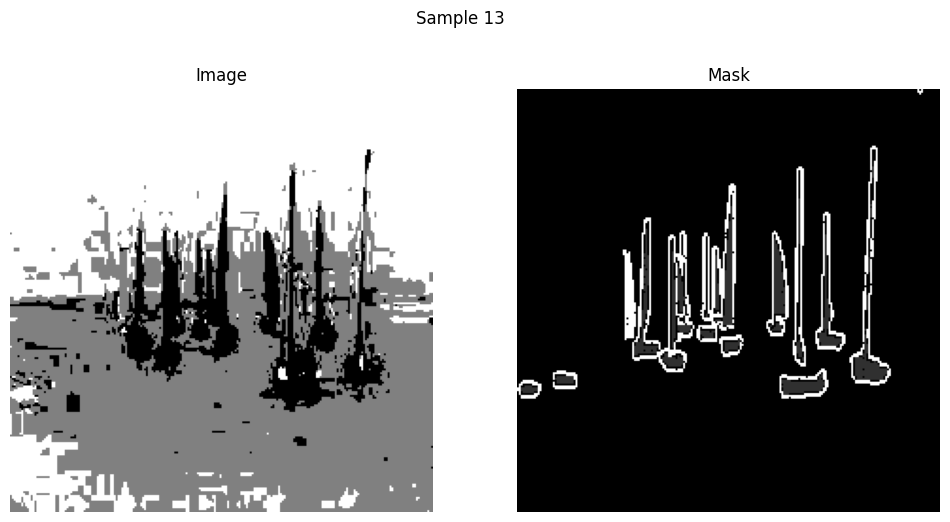

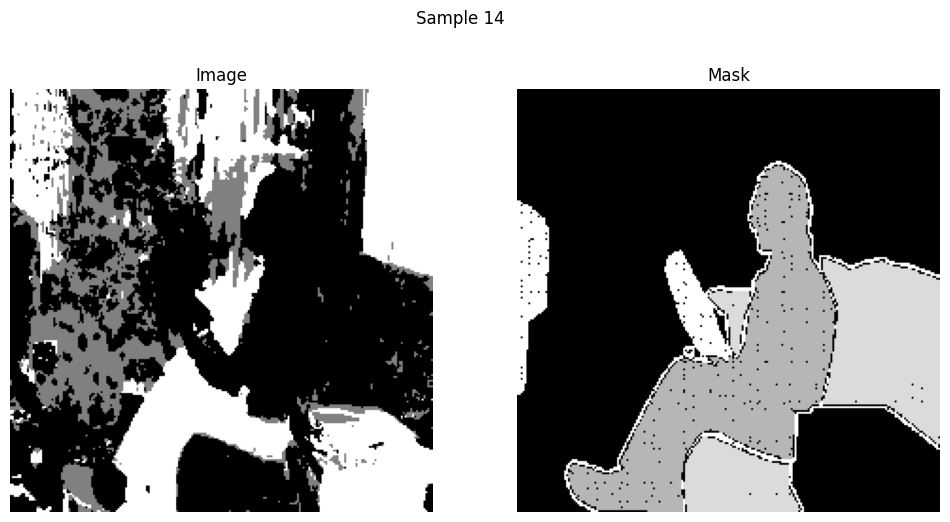

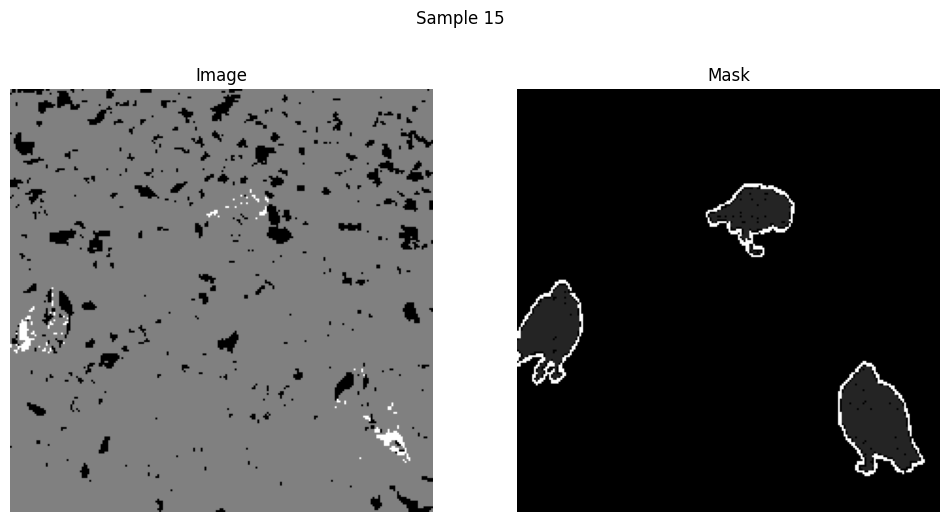

In [5]:
# Assuming 'images' and 'masks' are your datasets
for i in range(15):  # Display first 5 pairs to check
    plot_sample(train_imgs[i], train_masks[i], title=f"Sample {i+1}")

In [7]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model

tf.keras.backend.clear_session()

def conv_block(input_tensor, num_filters):
    """A block of two convolutional layers with ReLU activations and batch normalization."""
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def encoder_block(input_tensor, num_filters):
    """An encoder block with a convolution block followed by max pooling."""
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """A decoder block with upsampling, concatenation, and a convolution block."""
    x = UpSampling2D((2, 2))(input_tensor)
    x = concatenate([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

def unet_model(input_size=(224, 224, 3), num_classes=22):
    inputs = Input(input_size)

    # Encoder
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)
    
    # Bridge
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the U-Net model
model = unet_model()
model.summary()

# Training the model
history = model.fit(train_imgs, train_masks, validation_data=(val_imgs, val_masks), batch_size=8, epochs=50)

# Plot training and validation Dice loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training and Validation Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
